# Optimizing Regression Dataset Diamonds

So since we already know that depth is basically redundant because it can be calculated using x y and z anyway, its important to first look at the correlation and importance of these variables. This way, we can figure out which of these variables to drop. So I am mainly looking for this since I know that this dataset is already pretty clean.

Looking at the ydata alerts, it tells us that we only have a few problems. Unnamed: 0 will be dropped anyway so we can ignore these alerts but x, y, z, carat and price all have a very high correlation with each other.

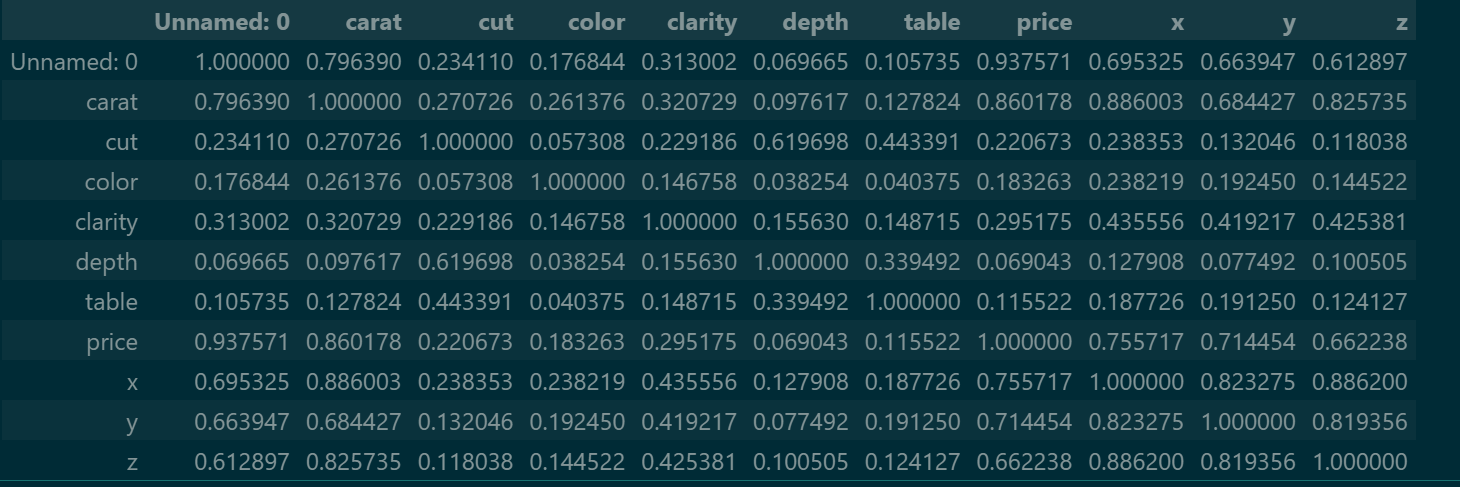

The phik matrix also shows the high correlation, do we really need all 5 of these variables? Let's check importance!

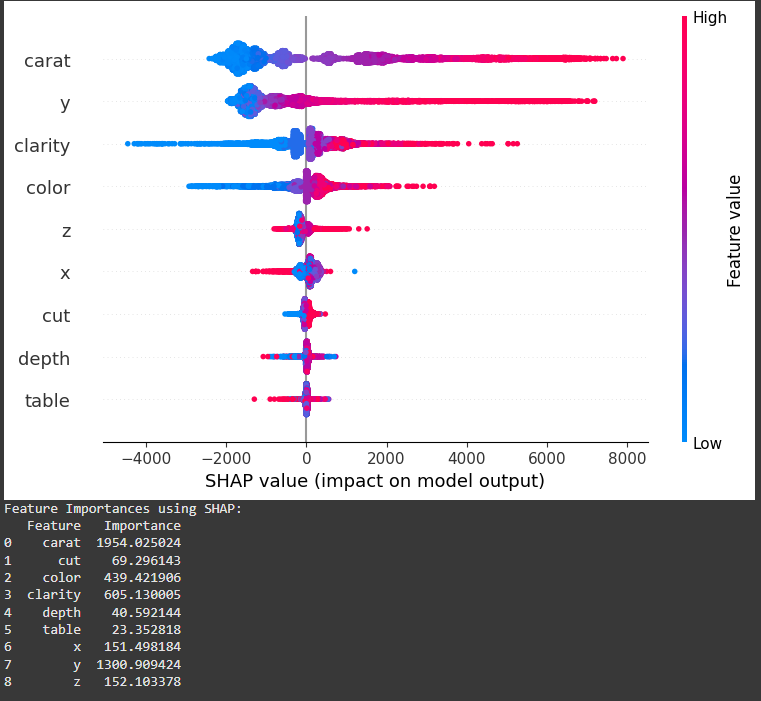

Carat rises above all other variables when it comes to importance. X, y and z are way lower, while also being significantly high, with y even being in second place.

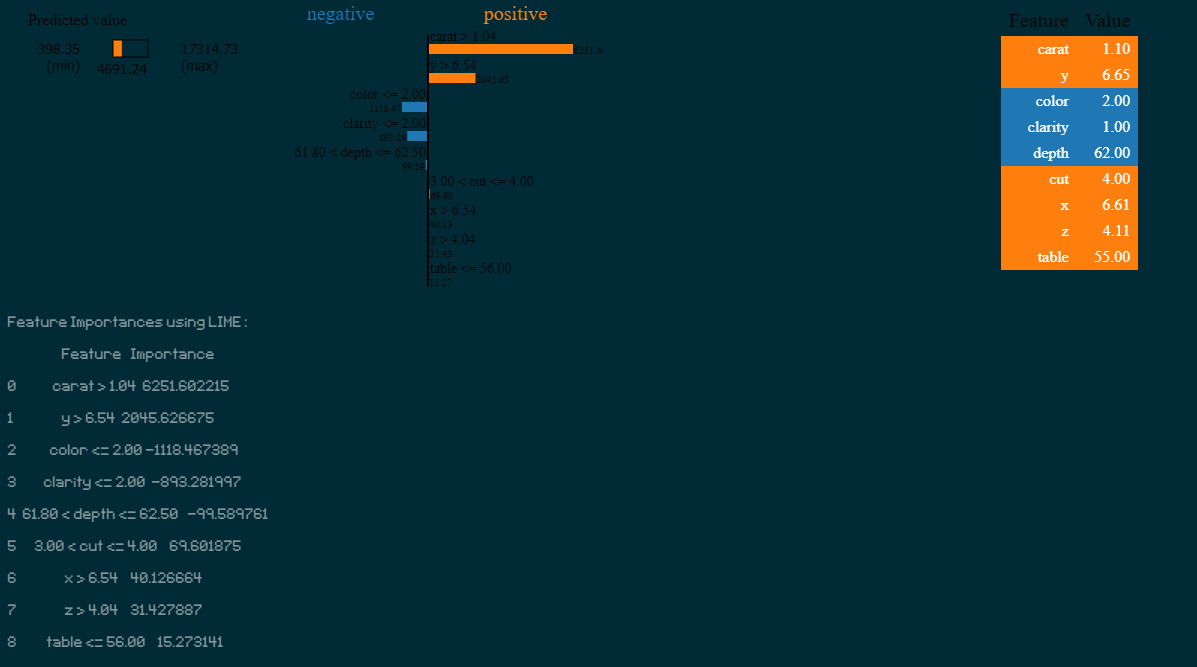

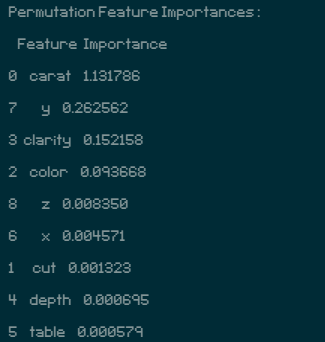

LIME and permutation importance also paint the same picture. With carat being the most important variable, strictly followed by y.<br>
I have concentrated so much on x,y and z that I didn't even notice that depth and table always seem to have a very low score

After further looking into the real life meaning of these variables, I have gathered that carat is basically just the weight of the diamond. That means, it tells us pretty much the same as the dimensions, because bigger crystals tend to weigh more. Which means we can straight up drop x, y and z as well as depth and table.

But should we really drop them? They could give very much needed information on the pricing?<br>
I thought so too, but if we look at online diamond price calculators, such as the ones I already listed in my last ANN modeling attempts, we can see what info they use:

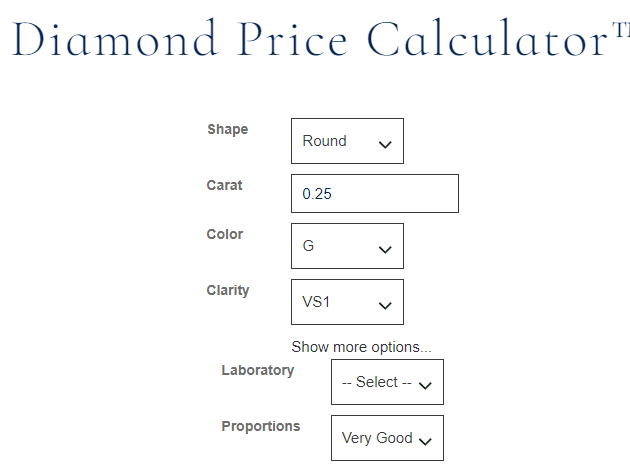

So okay, they have shape, carat, color, clarity, laboratory and proportions. Looking at other calculators, they tend to mainly focus on shape, carat, color and clarity. Since our dataset has no info on the shape of the diamond, we have to sit this one out. But I can't help to notice that some of the calculators don't ask for the cut of the diamond. Which is why I thought of maybe dropping it, since it also has not a high amount of importance of correlation with the other variables.

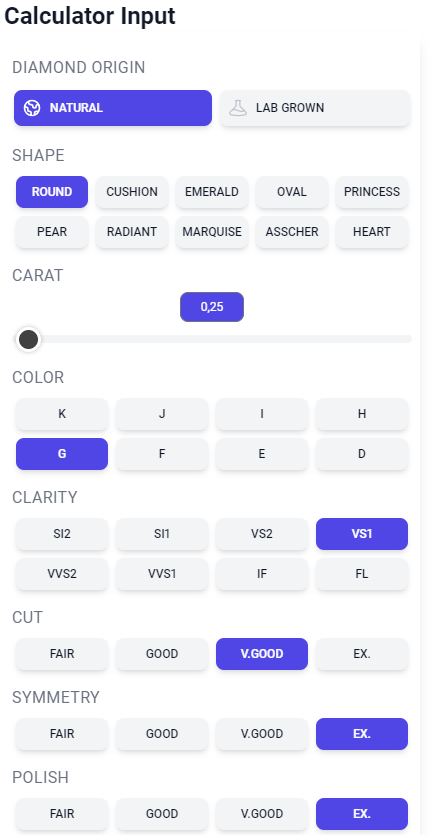

Then I remembered the other calculator, which actually takes the cut quality into consideration, so let's keep it.

In [1]:
import pandas as pd
from sklearn.linear_model import RANSACRegressor
from imblearn.under_sampling import RandomUnderSampler
from ctgan import CTGAN
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np


from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv("../OLD/data/diamonds.csv")

In [3]:
# Defining the map function
def binary_map_cut(x):
    return x.map({"Fair": 0, "Good": 1, "Very Good": 2, "Premium":3, "Ideal":4})

# Defining the map function
def binary_map_color(x):
    return x.map({"J": 0, "I": 1, "H": 2, "G": 3, "F":4, "E":5, "D":6})

# Defining the map function
def binary_map_clarity(x):
    return x.map({"I1":0, "SI2":1,"SI1":2,"VS2":3,"VS1":4,"VVS2":5,"VVS1":6,"IF":7})

# Applying the function to the housing list
df[["cut"]] = df[["cut"]].apply(binary_map_cut)
df[["color"]] = df[["color"]].apply(binary_map_color)
df[["clarity"]] = df[["clarity"]].apply(binary_map_clarity)

In [4]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75


In [5]:
df = df.drop(["Unnamed: 0", "depth", "table","x","y","z"], axis=1)

In [6]:
df.head()

,carat,cut,color,clarity,price
0,0.23,4,5,1,326
1,0.21,3,5,2,326
2,0.23,1,5,4,327
3,0.29,3,1,3,334
4,0.31,1,0,1,335


So much for the variables, now we need to look into another problem I came accross while creating the models back then. The distribution of the price is off. The documentation of diamonds significantly drops when the price increases. Since we already have a lot of data, I'm thinking of first deleting outliers using RANSAC and then trying undersampling to compress the data better.

## RANSAC

In [12]:
# since RANSAC is a regression algorithm, X/y -split
X = df.drop("price", axis=1)
y = df['price']

# initalize RANSAC regerssor and fit our data
# RANSAC needs a threshold in order to process data
# since our data is heavily skewed, we're gonna use this trick
ransac = RANSACRegressor(residual_threshold=np.std(y)*0.2) # I tried to lower the number to increase the outliers count, but this deleted to much data
ransac.fit(X, y)

# now we have split the result into 
# inliers and outliers
# inliers => good data, follows the distribution nicely
# outliers => are far away from the main distribution
# the ~-sign (tilde) in pandas DataFrames means "the opposite of"
# so in this case => get everything from DataFrame EXCEPT the inliers
inlier_mask = ransac.inlier_mask_
outliers = df[~inlier_mask]
inliers = df[inlier_mask]

print(f"Inliers: {len(inliers)}")
print(f"Outliers: {len(outliers)}")

Inliers: 37324
Outliers: 16616


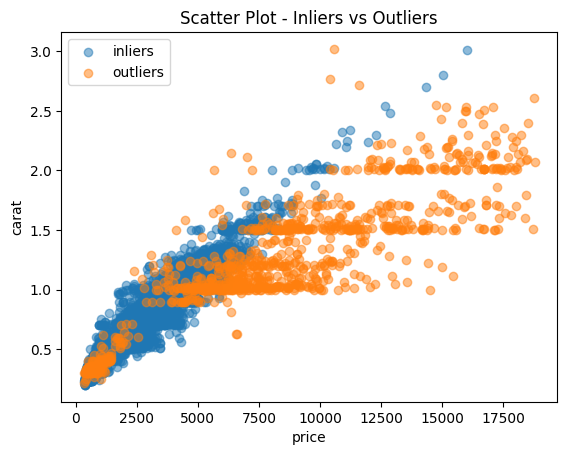

In [13]:
import matplotlib.pyplot as plt

variable = "price"
target = "carat"

# if you want to reduce the number of points visualized
# sample a small amount of points, for example 300-500
inliers_sample = inliers.sample(10000)
outliers_sample = outliers.sample(1000)

plt.scatter(inliers_sample[variable], inliers_sample[target], label="inliers", alpha=0.5)
plt.scatter(outliers_sample[variable], outliers_sample[target], label="outliers", alpha=0.5)

plt.xlabel(variable)
plt.ylabel(target)

plt.title("Scatter Plot - Inliers vs Outliers")
plt.legend()
plt.show()

This looks pretty good! It seems that RANSAC was able to increase the correlation by deleting the outliers.

In [14]:
dfAnalyze = inliers

<Axes: xlabel='price', ylabel='Count'>

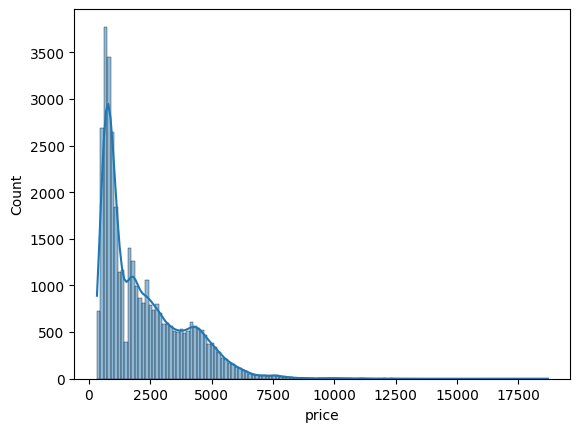

In [15]:
sns.histplot(data=dfAnalyze, x="price", kde=True)

This distribution is still not fixed, let's try to undersample.

<Axes: xlabel='carat', ylabel='Count'>

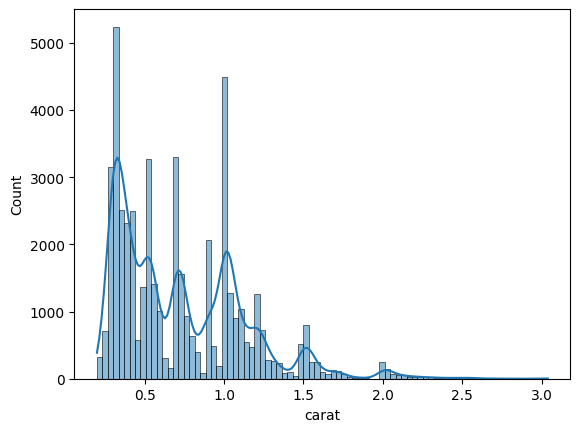

In [11]:
sns.histplot(data=dfAnalyze, x="carat", kde=True)

## Undersampling

In [24]:
# most of the data sampling and generation methods
# only work for classification targets
# we can still use these methods if we create a temporary binned
# version of our continuous variable. Just make sure you have enough 
# to capture the main idea of the whole target variable trend
target = "price"
inliers['target_binned'] = pd.cut(inliers[target], bins=4, labels=False)

C:\Users\Startklar\AppData\Local\Temp\ipykernel_22552\3628319913.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inliers['target_binned'] = pd.cut(inliers[target], bins=4, labels=False)


<Axes: xlabel='target_binned', ylabel='Count'>

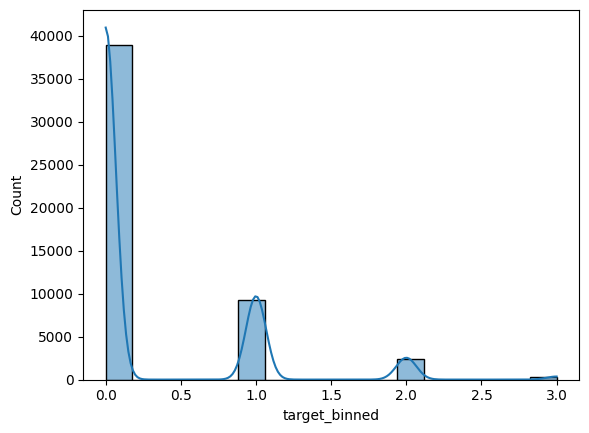

In [25]:
# let's see the binned version of the price
sns.histplot(data=inliers, x="target_binned", kde=True)

In [26]:
# let's have value counts, these are handy when 
# we use a sampling strategy
inliers['target_binned'].value_counts()

target_binned
0    38986
1     9243
2     2418
3      338
Name: count, dtype: int64

In [27]:
# the variables minus "target" variable
# of course the real target variable is "price"
# but since we are optimizing data here, we are using the binned-version
# as the "target variable"
variables = inliers.drop('target_binned', axis=1).columns
X = inliers[variables]
y = inliers['target_binned']

# initialize the undersampling sampler
# with auto, we actually lost 95% of the data, so let's use a specified sampling strategy
strategy = { 0: 600, 1: 700, 2: 750, 3: 338} #aim to keep at least 3000
sampler = RandomUnderSampler(sampling_strategy=strategy, random_state=321)

# perform undersampling
X_resampled, y_resampled = sampler.fit_resample(X, y)

# reconstruct the dataframe
df_resampled = pd.DataFrame(X_resampled, columns=variables)
df_resampled['target_binned'] = y_resampled

In [28]:
df_resampled

,carat,cut,color,clarity,price,target_binned
39490,0.41,3,5,4,1079,0
2004,0.71,3,5,3,3101,0
9009,1.01,3,2,2,4513,0
33333,0.41,2,3,3,827,0
45744,0.52,1,6,3,1701,0
...,...,...,...,...,...,...
25452,2.00,3,1,1,14208,3
25552,2.09,4,2,2,14383,3
26792,2.38,3,2,2,16643,3
27023,2.51,4,2,1,17162,3


In [29]:
dfAnalyze = df_resampled

<Axes: xlabel='price', ylabel='Count'>

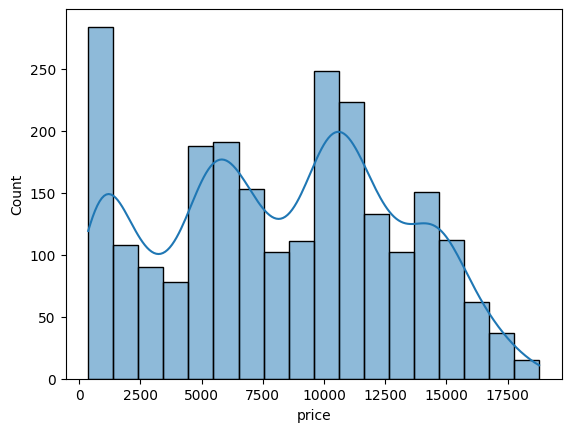

In [30]:
sns.histplot(data=dfAnalyze, x="price", kde=True)

<Axes: xlabel='carat', ylabel='Count'>

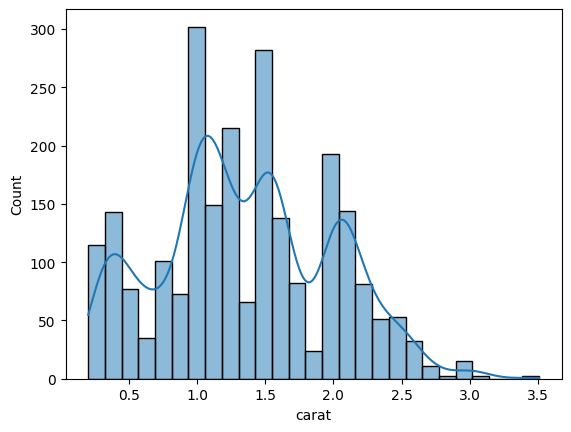

In [31]:
sns.histplot(data=dfAnalyze, x="carat", kde=True)

In [35]:
dfAnalyze = dfAnalyze.drop("target_binned", axis=1)

In [36]:
dfAnalyze.to_csv("../data/diamonds_optimized.csv", index=False)

## Changes

Ok so undersampling did not achieve what I wanted it to do, so let's ramp up the RANSAC outlier control, and just cut off the price after a certain point.

In [18]:
df = inliers
df.head

<bound method NDFrame.head of        carat  cut  color  clarity  price
0       0.23    4      5        1    326
1       0.21    3      5        2    326
2       0.23    1      5        4    327
3       0.29    3      1        3    334
6       0.24    2      1        6    336
...      ...  ...    ...      ...    ...
53935   0.72    4      6        2   2757
53936   0.72    1      6        2   2757
53937   0.70    2      6        2   2757
53938   0.86    3      2        1   2757
53939   0.75    4      6        1   2757

[37324 rows x 5 columns]>

In [19]:
df = df[df['price'] <= 2000]

In [20]:
df.head

<bound method NDFrame.head of        carat  cut  color  clarity  price
0       0.23    4      5        1    326
1       0.21    3      5        2    326
2       0.23    1      5        4    327
3       0.29    3      1        3    334
6       0.24    2      1        6    336
...      ...  ...    ...      ...    ...
53635   0.30    4      1        6    552
53636   0.30    4      6        2    552
53637   0.30    2      6        2    552
53638   0.30    4      6        2    552
53639   0.30    4      6        2    552

[21428 rows x 5 columns]>

<Axes: xlabel='price', ylabel='Count'>

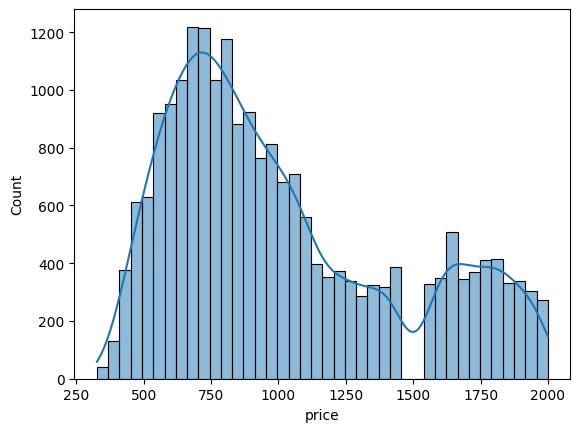

In [21]:
sns.histplot(data=df, x="price", kde=True)

<Axes: xlabel='carat', ylabel='Count'>

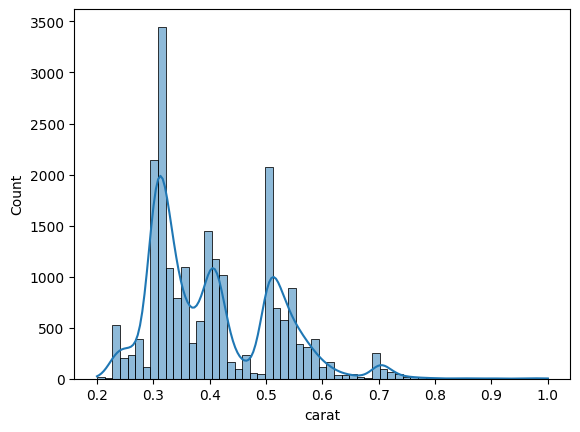

In [22]:
sns.histplot(data=df, x="carat", kde=True)

seems ok, let's try this then

In [24]:
df.to_csv("../data/diamonds_optimized2.csv", index=False)